## データとかを見るコード

In [12]:
from pathlib import Path

import yaml
import numpy as np

from matplotlib import pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
from IPython.display import HTML

from check_diffusion_sine.config import DatasetConfig
from check_diffusion_sine.dataset import preprocess, DatasetInput, get_datas, create_dataset
from check_diffusion_sine.generator import Generator
from check_diffusion_sine.config import Config

import torch

### データを可視化する
* target_wave: 予測対象の波形データ。サイン波。
* noise_wave: diffusion最初期の完全ランダムなノイズ。正規分布に従う。
* input_wave: 時刻tを元にした配分比でノイズを混ぜた波形データ。これからtarget-noiseの方向を予測する。

tensor(0.2260)


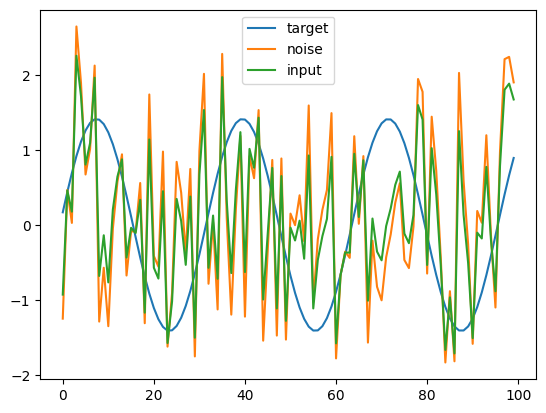

In [2]:
datasets = create_dataset(
    config=DatasetConfig(
        train_num=100,
        lf0_low=5.7,
        lf0_high=6.7,
        sampling_rate=24000,
        min_sampling_length=100,
        max_sampling_length=100,
        test_num=10,
        seed=0,
    ),
)

datas = datasets["train"]
for d in [datas[0]]:
    plt.plot(d["target_wave"].numpy(), label="target")
    plt.plot(d["noise_wave"].numpy(), label="noise")
    plt.plot(d["input_wave"].numpy(), label="input")
    # plt.plot(d["target_wave"].numpy() - d["noise_wave"].numpy(), label="diff")
    print(d["t"])
    plt.legend()

### 生成してみる
* 300エポック（50000イテレーション）くらいのモデルだと、ステップ30くらいかければかなりきれいなサイン波が作れる。
* ステップ数を大幅に増やすと逆効果になる。
* より小さいモデルで学習させたとき、エポック数も増やしていくと逆に波が汚くなっていった。

In [57]:
config_yaml_path = Path("config.yaml")
predictor_path = Path("predictor_295.pth")

with config_yaml_path.open() as f:
    config_dict = yaml.safe_load(f)
config = Config.from_dict(config_dict)

generator = Generator(config=config, predictor=predictor_path, use_gpu=True)
# generator = Generator(config=config, predictor=predictor_path, use_gpu=False)

datas = datasets["train"]
# 一番lf0が6.2に近いものを得る
d = sorted(datas, key=lambda d: abs(d["lf0"].mean() - 6.2))[0]

output_steps = generator(
    noise_wave_list=[d["noise_wave"]],
    lf0_list=[d["lf0"]],
    step_num=30,
    return_every_step=True,
)

fig = plt.figure(figsize=(10, 3))
plt.ylim(-2.3, 2.3)

ims = []
for i, output in enumerate(output_steps):
    a = plt.plot(d["target_wave"].numpy(), label="target", color="black")
    b = plt.plot(output[0]["wave"].detach().cpu().numpy(), label=f"output {i}", color=cm.cool(i / len(output_steps)))
    c = plt.text(0, 1.5, f"step: {i+1}")
    ims.append(a + b + [c])

plt.close()

ani = animation.ArtistAnimation(fig,ims,interval=50) # アニメ関数
HTML(ani.to_html5_video()) # HTML5 Videoで表示
# HTML(ani.to_jshtml())    # Javascript HTMLで表示